In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
import pandas as pd
import scanpy as sc
import hexagdly
import math

/tmp/ipykernel_20324/3209162279.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def data_processing(data_path, file_nums, k):
    labels = []
    nums = file_nums
    features = np.zeros((len(nums), k, 64, 78))
    for i in range(len(nums)):
        print(f'processing no. {nums[i]}')
        num = nums[i]
        cells=pd.read_csv(f'{data_path}/{num}/ck17_{num}_cell_barcodes.txt')
        gene=pd.read_csv(f'{data_path}/{num}/ck17_{num}_gene_names.txt', dtype={
            'no': 'int64',
            'gene name': 'string'
        })
        meta=pd.read_csv(f'{data_path}/{num}/ck17_{num}_metadata.txt')
        if 'barcode' not in meta.columns:
            meta=meta.rename(columns={"Unnamed: 0":"barcode"})
        adata=sc.read_mtx(f'{data_path}/{num}/ck17_{num}_gex_data.txt').T
        position = pd.read_csv(f'{data_path}/{num}/ck17_{num}_tissue_positions_list.csv', names=['in_tissue', 'row', 'col', 'pixel_row', 'pixel_col'])
        position['barcode'] = position.index
        adata.obs.index=cells['x']
        adata.var.index=gene['x']
        meta.index=meta.iloc[:,0]
        adata.obs=meta
    
        adata.obs.index.name='idx'
        obs = adata.obs.merge(position[['row', 'col', 'barcode']], on='barcode', how='inner')
        # get the label: 0 for non-responder and 1 for responder
        if obs['ici_response'].unique().item() == 'NR':
            labels.append(0)
        else:
            labels.append(1)

        # get geneswith k-largest normalized gex
        gex_filter = np.asarray(np.sum(adata.X.todense()>0,axis=0)/2261)
        gene_no = np.argpartition(gex_filter, len(gex_filter) - k)
        gex_total = np.asarray(adata.X.todense())
    
        for j in range(k):
            for idx, row in obs.iterrows():
                hex_row = row['row']
                hex_col = row['col']
                mat_col = hex_row
                mat_row = math.floor(hex_col/2)
                features[i][j][mat_row][mat_col] = gex_total[idx][gene_no[0][-k:][j]]

    return features, labels

In [3]:
def to_dataloader(features, labels, batch_size=2):
    data = torch.tensor(features, dtype=torch.float32)
    labels = np.asarray(labels)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    train_data, val_data = data[:7], data[7:]
    train_labels, val_labels = labels[:7], labels[7:]
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [4]:
class hex_model(nn.Module):
    def __init__(self, nin):          
        super(hex_model, self).__init__()
        self.name = 'hex_model'
        self.hexconv1 = hexagdly.Conv2d(in_channels = nin, out_channels = 128, \
                                         kernel_size = 2, stride = 1, bias=True)
        self.hexpool1 = hexagdly.MaxPool2d(kernel_size = 2, stride = 2)
        self.hexconv2 = hexagdly.Conv2d(128, 64, 2, 1, bias=True)
        self.hexpool2 = hexagdly.MaxPool2d(kernel_size = 2, stride = 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 32 * 39, 512)
        self.fc2 = nn.Linear(512, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.hexconv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.hexpool1(x)

        x = self.hexconv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.hexpool2(x)

        x = self.dropout(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [5]:
input_channel = 1000
features, labels = data_processing("Visium", [5,7,12,19,208,209,1294], input_channel)
train_loader, val_loader = to_dataloader(features, labels, 2)

processing no. 5
processing no. 7
processing no. 12
processing no. 19
processing no. 208
processing no. 209
processing no. 1294


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = hex_model(input_channel).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 25
training_losses, val_losses = [], []
for epoch in range(epochs):
    # training period
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    training_losses.append(running_loss/len(train_loader))

    # evaluation period
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss/len(val_loader))
    
    print(f'Epoch {epoch+1}, Train Loss: {training_losses[-1]}, Validation Loss: {val_losses[-1]}')

Epoch 1, Train Loss: 2122.7989773899317, Validation Loss: 14757.534042358398
Epoch 2, Train Loss: 3909.077781677246, Validation Loss: 47744.28747558594
Epoch 3, Train Loss: 30596.69207763672, Validation Loss: 3474.94189453125
Epoch 4, Train Loss: 32047.4814453125, Validation Loss: 15202.94889831543
Epoch 5, Train Loss: 25542.773193359375, Validation Loss: 19131.808837890625
Epoch 6, Train Loss: 15608.280029296875, Validation Loss: 2864.0740814208984
Epoch 7, Train Loss: 9103.77099609375, Validation Loss: 24428.491821289062
Epoch 8, Train Loss: 22207.87451171875, Validation Loss: 1040.0990737080574
Epoch 9, Train Loss: 634.8968963623047, Validation Loss: 124.59781014919281
Epoch 10, Train Loss: 661.9822235107422, Validation Loss: 108.0057144165039
Epoch 11, Train Loss: 464.16291332244873, Validation Loss: 6.75291234254837
Epoch 12, Train Loss: 278.10279417037964, Validation Loss: 60.39085674285889
Epoch 13, Train Loss: 391.2988052368164, Validation Loss: 55.678175926208496
Epoch 14, Tra

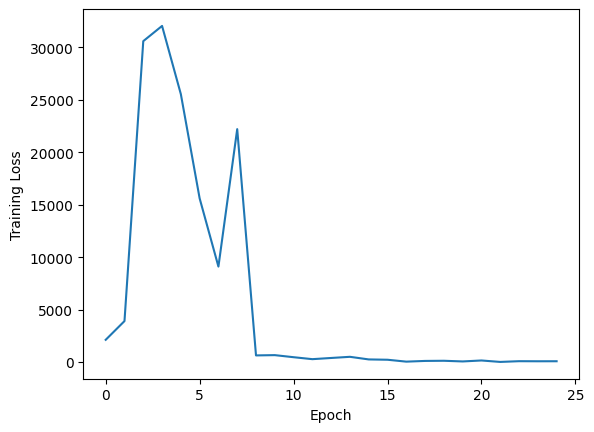

In [28]:
import matplotlib.pyplot as plt
plt.plot(training_losses, label = 'Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

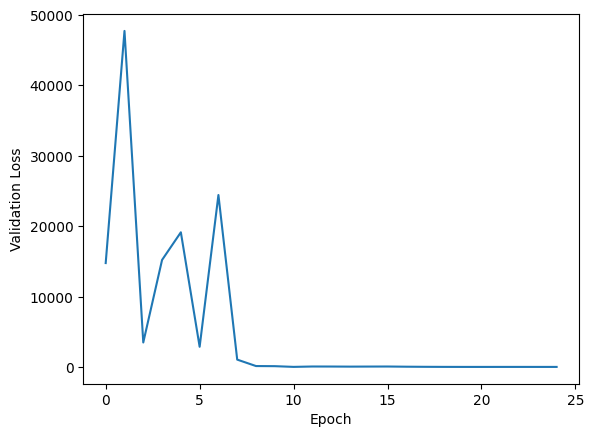

In [29]:
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()